Mounted at /content/drive
/content/drive/MyDrive


Epoch 1/150
210/210 [==============================] - 74s 297ms/step - loss: 2.6706 - accuracy: 0.1817 - val_loss: 3.2553 - val_accuracy: 0.1471
Epoch 2/150
210/210 [==============================] - 63s 297ms/step - loss: 2.0194 - accuracy: 0.3066 - val_loss: 2.3130 - val_accuracy: 0.1832
Epoch 3/150
210/210 [==============================] - 64s 306ms/step - loss: 1.6566 - accuracy: 0.4213 - val_loss: 2.2167 - val_accuracy: 0.2196
Epoch 4/150
210/210 [==============================] - 64s 307ms/step - loss: 1.5009 - accuracy: 0.4674 - val_loss: 1.6836 - val_accuracy: 0.3803
Epoch 5/150
210/210 [==============================] - 64s 305ms/step - loss: 1.4060 - accuracy: 0.4999 - val_loss: 1.3619 - val_accuracy: 0.5287
Epoch 6/150
210/210 [==============================] - 65s 308ms/step - loss: 1.3390 - accuracy: 0.5268 - val_loss: 1.3301 - val_accuracy: 0.5460
Epoch 7/150
210/210 [==============================] - 61s 293ms/step - loss: 1.2802 - accuracy: 0.5480 - val_loss: 1.4560 -

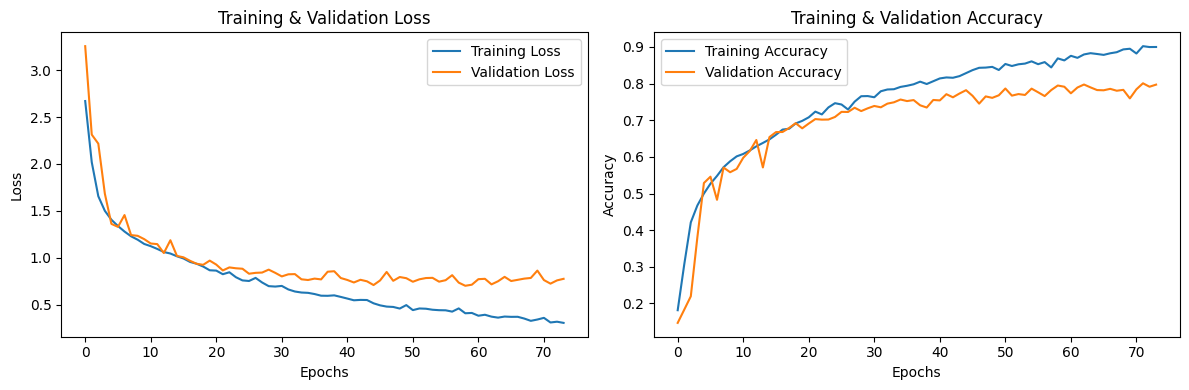

52/52 [==============================] - 1s 23ms/step - loss: 0.7026 - accuracy: 0.7947
The test loss is: 0.7025743722915649

The best test accuracy is: 79.4661819934845
104/104 [==============================] - 3s 25ms/step - loss: 0.7026 - accuracy: 0.7947
The test loss is: 0.7025743126869202

The best test accuracy is: 79.4661819934845


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from google.colab import files
import matplotlib.pyplot as plt
%cd 'drive/MyDrive'
# Load Data
#uploaded = files.upload()
df = pd.read_csv('features_3_sec.csv')

# Drop unnecessary column
df = df.drop(labels='filename', axis=1)

# Encode Labels
class_list = df.iloc[:, -1]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(class_list)

# Standardize Features
scaler = StandardScaler()
X = scaler.fit_transform(np.array(df.iloc[:, :-1], dtype=float))

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Reshape input data for RNN
X_train_rnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_rnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Calculate class weights
class_counts = np.bincount(y_train)
total_samples = len(y_train)
class_weights = total_samples / (len(class_counts) * class_counts)
class_weight_dict = dict(zip(range(len(class_counts)), class_weights))

# Build an improved RNN Model with GRU, BatchNormalization, increased dropout, and adjusted batch size
model = Sequential([
    GRU(256, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    BatchNormalization(),
    Dropout(0.5),
    GRU(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Adjust the learning rate using a schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)

# Compile and Train RNN Model with early stopping
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_history = model.fit(X_train_rnn, y_train, validation_data=(X_test_rnn, y_test), epochs=150, batch_size=32, callbacks=[early_stopping], class_weight=class_weight_dict)
plt.figure(figsize=(12, 4))

# Plot Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate Model
test_loss, test_acc = model.evaluate(X_test_rnn, y_test, batch_size=64)
print("The test loss is:", test_loss)
print("\nThe best test accuracy is:", test_acc * 100)
# Evaluate Model
test_loss, test_acc = model.evaluate(X_test_rnn, y_test, batch_size=32)
print("The test loss is:", test_loss)
print("\nThe best test accuracy is:", test_acc * 100)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')